# Value-at-risk calculations

The basic idea behind the value-at-risk calculation is that we're going to look at the historical returns of a portfolio of securities and run many simulations to determine the range of returns we can expect from these.  We can then predict, over a given time horizon, what our expected loss is at a given probability, e.g., we might say that there is less than a 10% chance that the portfolio will lose more than $1,000,000.

Note that this is a didactic example and consequently makes some simplifying assumptions about the composition of the portfolio (i.e., only long positions in common stocks, so no options, dividends, or short selling) and the behavior of the market (i.e., day-to-day return percentages are normally-distributed and independent).  Do not use this code to guide actual investment decisions!

## Basic setup

Here we import the `pyspark` module and set up a `SparkSession`.

In [1]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext

spark = SparkSession.builder.master("local[*]").getOrCreate()

## Loading the data

We'll start by loading the data (from the WikiEOD dataset of freely-available stock closing prices).

In [2]:
df = spark.read.load("/data/wikieod.parquet")

## Calculating historical returns

We'll use Spark's windowing functions over data frames to determine the percentage change in each security from the previous close to each day's close.  Basically, we'll add a column to our data frame that represents the percentage change from the previous day's close (that is, `lag("close", 1)` when partitioned by ticker symbol and ordered by date) and the current day's close (that is, `col("close")`).

In [3]:
from pyspark.sql import Window
from pyspark.sql.functions import lag, col, avg, variance

ddf = df.select("ticker", "date", "close").withColumn("change", (col("close") / lag("close", 1).over(Window.partitionBy("ticker").orderBy(df["date"])) - 1.0) * 100)
ddf.show(10)

+------+----------+-----+------------------+
|ticker|      date|close|            change|
+------+----------+-----+------------------+
|  ACFN|1992-02-11|10.12|              null|
|  ACFN|1992-02-12|10.75| 6.225296442687744|
|  ACFN|1992-02-13| 10.0|-6.976744186046513|
|  ACFN|1992-02-14|10.12| 1.200000000000001|
|  ACFN|1992-02-18|10.25|1.2845849802371578|
|  ACFN|1992-02-19|10.38|1.2682926829268304|
|  ACFN|1992-02-20| 12.0|15.606936416184958|
|  ACFN|1992-02-21|13.12| 9.333333333333327|
|  ACFN|1992-02-24| 12.0|-8.536585365853655|
|  ACFN|1992-02-25|12.38| 3.166666666666673|
+------+----------+-----+------------------+
only showing top 10 rows



# Plotting some example return distributions

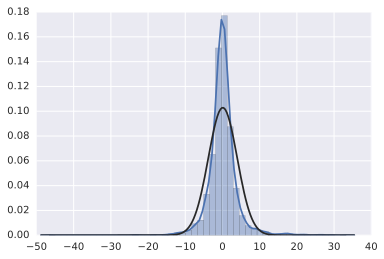

In [26]:
symbols = ddf.select("ticker").distinct().sample(True, 0.01).rdd.map(lambda l: l["ticker"]).collect()

from scipy import stats

rdist = ddf.filter(ddf["ticker"] == "RHT").select("change").rdd.map(lambda r: r["change"]).filter(lambda c: c is not None).collect()
import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.distplot(rdist, fit=stats.norm)

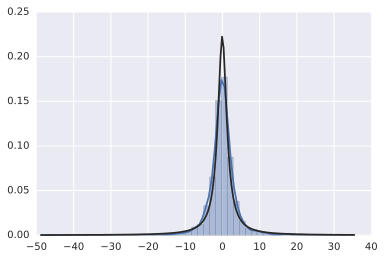

In [39]:
sns.distplot(rdist, fit=stats.cauchy)

## Characterizing expected return distributions

With the range of changes now available, we can calculate our expected returns for each security.  Since this is a simple example, we'll assume that returns are normal (in the real world, you'd want to use a distribution with heavier tails or a more sophisticated technique altogether).  We can calculate the parameters for each security's distribution as follows:

In [ ]:
from pyspark.sql.functions import sqrt
mv = ddf.groupBy("ticker").agg(avg("change").alias("mean"), sqrt(variance("change")).alias("stddev"))
mv.show(10)

Since there are only about 3,000 ticker symbols in our data set, we can easily collect these in driver memory for use in our simulation:

In [ ]:
dist_map = mv.rdd.map(lambda r: (r[0], (r[1], r[2]))).collectAsMap()
dist_map["RHT"]

## Getting current security prices

We'll now identify the latest price for each security in our dataset:

In [ ]:
from pyspark.sql.functions import first
priceDF = ddf.orderBy("date", ascending=False).groupBy("ticker").agg(first("close").alias("price"), first("date").alias("date"))
priceDF.show(10)

prices = priceDF.rdd.map(lambda r: (r[0], r[1])).collectAsMap()

## Setting up a simulation

We'll now define our simulation.  This involves three steps: 

1.  We'll start by generating a random portfolio of securities (a map from ticker symbols to values); then, 
2.  we'll decide how many simulations to run and generate a random seed for each; and, finally
3.  we'll actually run the simulation for a given number of training days, updating the value of our portfolio with random returns sampled from the distribution of historical returns.

Generating the random portfolio is pretty straightforward:

In [ ]:
from random import randint, seed

def random_portfolio(symbols):
    result = {}
    for s in symbols:
        result[s] = prices[s] * (randint(1, 1000) * 11)
    return result

def portfolio_value(pf):
    return sum([v for v in pf.values()])

seed(0xdea110c8)

portfolio = random_portfolio(ddf.select("ticker").distinct().sample(True, 0.01, 0xdea110c8).rdd.map(lambda r: r[0]).collect())

As is generating a collection of random seeds:

In [ ]:
def seeds(count):
    return [randint(0, 1 << 32 - 1) for i in range(count)]

We'll define a single step of our simulation (and, subsequently, a whole run of the simulation) next:

In [ ]:
def simstep(pf, params, prng):
    def daily_return(sym):
        mean, stddev = params[sym]
        change = (prng.normalvariate(mean, stddev) + 100) / 100.0
        return change
    return dict([(s, daily_return(s) * v) for s, v in pf.items()])

def simulate(seed, pf, params, days):
    from random import Random
    prng = Random()
    prng.seed(seed)
    pf = pf.copy()
    
    for day in range(days):
        pf = simstep(pf, params, prng)
    return pf

Now we have everything we need to actually run the simulation.  For each seed, we'll spawn a Spark job to simulate 5 days of activity on our portfolio and then return the total dollar value of our gain or loss at the end of the period.

In [ ]:
sc = spark.sparkContext
seed_rdd = sc.parallelize(seeds(10000))
bparams = sc.broadcast(dist_map)
bpf = sc.broadcast(portfolio)
initial_value = portfolio_value(portfolio)

results = seed_rdd.map(lambda s: portfolio_value(simulate(s, bpf.value, bparams.value, 5)) - initial_value)

In [ ]:
simulated_results = list(zip(results.collect(), seed_rdd.collect()))
simulated_values = [v for (v, _) in simulated_results]
simulated_values.sort()

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

_ = plt.hist(simulated_values, bins=25)


In [ ]:
xvals = [float(i) / len(simulated_values) for i in range(len(simulated_values))]
_ = plt.plot(xvals, simulated_values)

Since the market historically trends up, we have a better than even chance of not losing money in our simulation.  We can see the 5% value at risk over our time horizon.

In [ ]:
simulated_values[int(len(simulated_values) * 0.05)]

## Visualizing random walks

Finally, let's look at some example simulation runs to see how the portfolio value changes over time.  We'll take the runs with the best and worst returns and also the runs at each decile.  To visualize our simulation, we'll need a slightly different `simulate` function:

In [ ]:
def simulate_with_history(seed, pf, params, days):
    from random import Random
    prng = Random()
    prng.seed(seed)
    pf = pf.copy()
    values = [portfolio_value(pf)]
    
    for day in range(days):
        pf = simstep(pf, params, prng)
        values.append(portfolio_value(pf))
    return values

We'll now repeat the simulation on eleven of our seeds from the earlier run, collecting history for each:

In [ ]:
simulated_results.sort()
eleven_results = [simulated_results[int((len(simulated_results) - 1) * i / 10)] for i in range(11)]
eleven_seeds = sc.parallelize([seed for (_, seed) in eleven_results])
walks = eleven_seeds.map(lambda s: simulate_with_history(s, bpf.value, bparams.value, 5))

walk_results = walks.collect()

In [ ]:
_ = plt.plot([list(c) for c in zip(*walk_results)])